In [13]:
import ROOT
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image
import numpy as np
from uncertainties import ufloat
from uncertainties.umath import *

# The Issue
---
- Recent target polarization analyses from myself (Gregory) and Harut have unearthed a considerable discrepancy in our Pt for various runs, despite approaching Pt from inclusive asymmetries of the same data set.
- The goal of this notebook is to provide enough information to convincingly cross-check that the Tpol extracted from MY analysis is absent of any bugs.

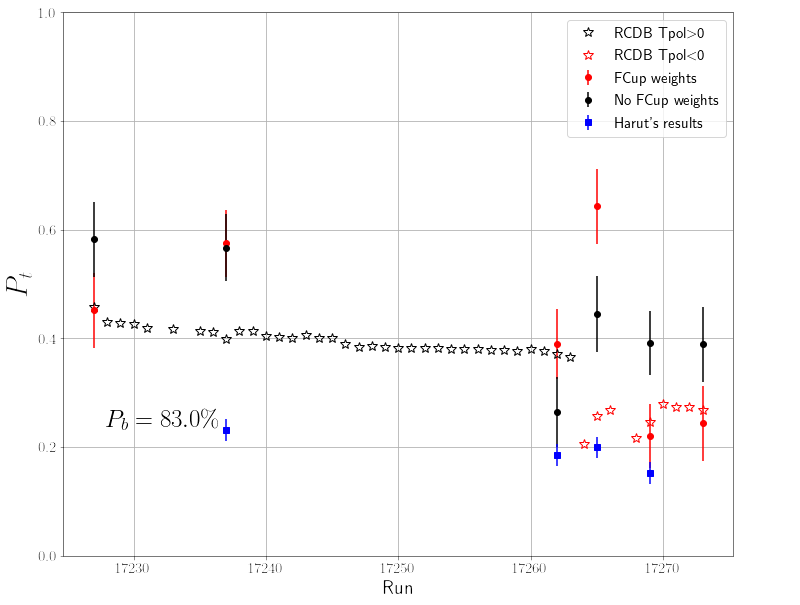

In [14]:
Image("img/ND3runs.png",width=400,height=400)

# Basic Run Info
---
All the following pieces of information are pulled from the RCDB website (https://clasweb.jlab.org/rcdb/runs/info/17265)


In [8]:
HWP="in"
target_polarization = -0.257376

Since A_LL is greater than zero for inclusive studies, we would expect that, for an inserted HWP and negative target polarization relative to beam direction, that N+ > N- , where...
- N+ = Number of events with helicity = +1
- N- = Number of events with helicity = -1

# Scripts+Data for the crosscheck
---
The relevant script for the cross check is titled "sidisdvcs_17265.C". This script reads in the /volatile/clas12/rg-c/production/ana_data/HBT/8.3.2/dst/train/sidisdvcs/sidisdvcs_017265.hipo file and outputs a TTree with 3 branches, and a TH1F with 2 bins. These TObjects are saved in data17265.root

- The TTree contains event-by-event helicity, x, and Q2. This was calculated by finding the status<0 (scattered electron) particle (from REC::Particle) and calculating x,Q2 with four momentums. The initial beam energy was pulled from the RCDB to be 10.5563 GeV. The helicity is read in by the line `c12->event()->getHelicity()`

- The TH1F contains two bins. The first contains the total fcupgated for when the beam helicity was +1. The second bin contains the total fcupgated for when the beam helicity was -1. These were incremented by reading each entry of HEL::scaler in the hipo file

Total Number of Entries:  691491
FCupgated for Helicity = +1 :  6118.32763671875
FCupgated for Helicity = -1 :  6060.94189453125
FCupgated asymmetry = 0.47%
******************************************************************************
*Tree    :tree      :                                                        *
*Entries :   691491 : Total =        13870144 bytes  File  Size =   10691713 *
*        :          : Tree compression factor =   1.30                       *
******************************************************************************
*Br    0 :helicity  : helicity/I                                             *
*Entries :   691491 : Total  Size=    2774546 bytes  File Size  =     141237 *
*Baskets :       87 : Basket Size=      32000 bytes  Compression=  19.63     *
*............................................................................*
*Br    1 :x         : x/D                                                    *
*Entries :   691491 : Total  Size=    5547537 bytes  

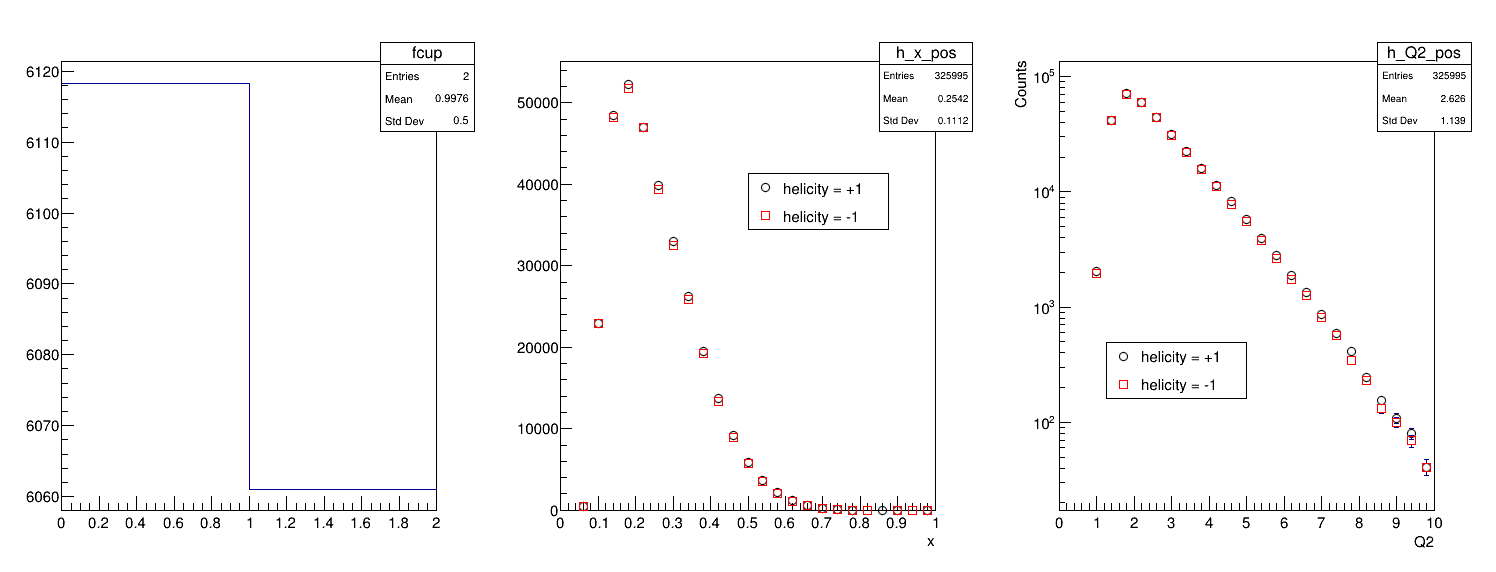

In [9]:
fIn = ROOT.TFile("data17265.root","READ")
tIn = fIn.Get("tree")
hIn = fIn.Get("fcup")

Nentries=tIn.GetEntries()
fcg_pos=hIn.GetBinContent(1)
fcg_neg=hIn.GetBinContent(2)
print("Total Number of Entries: ",tIn.GetEntries())
print("FCupgated for Helicity = +1 : ",fcg_pos)
print("FCupgated for Helicity = -1 : ",fcg_neg)
print("FCupgated asymmetry = {:.2f}%".format(100*(fcg_pos-fcg_neg)/(fcg_pos+fcg_neg)))
tIn.Print()

# Plot data from rootfile
c = ROOT.TCanvas("c","c",1500,600)
c.Divide(3,1)
c.cd(1)
hIn.Draw()
c.cd(2)
#ROOT.gPad.SetLogy(1)
ROOT.gStyle.SetErrorX(0)
h_x_pos = ROOT.TH1F("h_x_pos",";x;Counts",25,0,1); h_x_pos.SetMarkerColor(1); h_x_pos.SetMarkerStyle(24);
h_x_neg = ROOT.TH1F("h_x_neg",";x;Counts",25,0,1); h_x_neg.SetMarkerColor(2); h_x_neg.SetMarkerStyle(25);
tIn.Draw("x>>h_x_pos","helicity==1","E1")
tIn.Draw("x>>h_x_neg","helicity==-1","E1 same")
legend1=ROOT.TLegend(0.5,0.6,0.8,0.7)
legend1.AddEntry(h_x_pos,"helicity = +1","p")
legend1.AddEntry(h_x_neg,"helicity = -1","p")
legend1.Draw("same")
c.cd(3)
ROOT.gPad.SetLogy(1)
h_Q2_pos = ROOT.TH1F("h_Q2_pos",";Q2;Counts",25,0,10); h_Q2_pos.SetMarkerColor(1); h_Q2_pos.SetMarkerStyle(24);
h_Q2_neg = ROOT.TH1F("h_Q2_neg",";Q2;Counts",25,0,10); h_Q2_neg.SetMarkerColor(2); h_Q2_neg.SetMarkerStyle(25);
tIn.Draw("Q2>>h_Q2_pos","helicity==1","E1")
tIn.Draw("Q2>>h_Q2_neg","helicity==-1","E1 same")
legend2=ROOT.TLegend(0.2,0.3,0.5,0.4)
legend2.AddEntry(h_Q2_pos,"helicity = +1","p")
legend2.AddEntry(h_Q2_neg,"helicity = -1","p")
legend2.Draw("same")
c.Draw()

# Extracting the x-Q2 bins
---
The following code reads in Sebastian's A_LL_deuteron table and extracts the x-Q2 2d bins

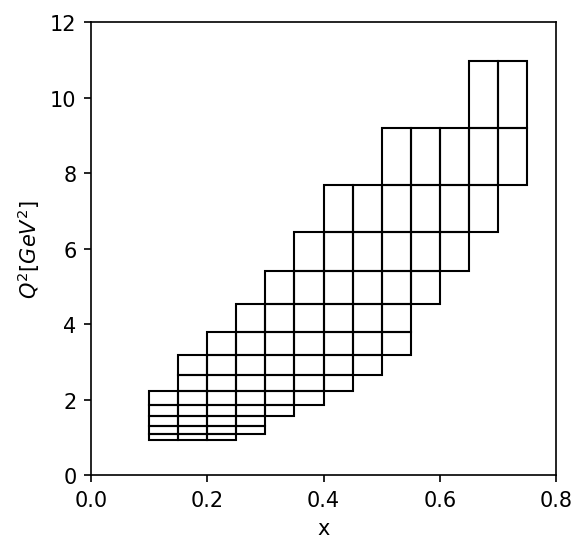

In [10]:
df_A_LL = pd.read_csv("sebastian_A_LL_d.txt",header=None,sep=" ",names=["xmin","xmax","Q2min","Q2max","A_||"])
xl=df_A_LL["xmin"].to_numpy()
xh=df_A_LL["xmax"].to_numpy()
yl=df_A_LL["Q2min"].to_numpy()
yh=df_A_LL["Q2max"].to_numpy()
A_LLarr=df_A_LL["A_||"].to_numpy()
xy=[[x,y] for x,y in zip(xl,yl)]
w=xh-xl
h=yh-yl
fig,axs=plt.subplots(1,1,figsize=(4,4),dpi=150)
axs.set_xlabel("x")
axs.set_ylabel("$Q^{2} [GeV^{2}]$")
for a,b,c in zip(xy,w,h):
    axs.add_patch(matplotlib.patches.Rectangle(a,b,c,fill=None,alpha=1))
axs.set_xlim(0,0.8)
axs.set_ylim(0,12)
plt.show()

# Pulling dilution factors
---
Previous code I have written produces the dilution factors for NH3 and ND3 based on the above binning. We pull these from the corresponding csv here

In [11]:
dilutiondf=pd.read_csv("/work/clas12/users/gmat/rgc_dilution_factor_v4.csv")
Xl=dilutiondf["xmin"].to_numpy()
Xh=dilutiondf["xmax"].to_numpy()
Yl=dilutiondf["Q2min"].to_numpy()
Yh=dilutiondf["Q2max"].to_numpy()
df_ND3 = dilutiondf["df_ND3"].to_numpy()
df_err_ND3 = dilutiondf["df_err_ND3"].to_numpy()
XY =[[x,y] for x,y in zip(Xl,Yl)]

# Calculating the Target Polarization
---

In [12]:
# Creating the 2d histograms
xbins = np.unique(np.concatenate([xl,xh]))
Q2bins = np.unique(np.concatenate([yl,yh]))

h_plus = ROOT.TH2F("h_plus","h_plus",len(xbins)-1,xbins,len(Q2bins)-1,Q2bins)
h_minus = ROOT.TH2F("h_minus","h_minus",len(xbins)-1,xbins,len(Q2bins)-1,Q2bins)

# Error propagation
h_plus.Sumw2()
h_minus.Sumw2()

zhat = 0
if(target_polarization>0):
    zhat=1
else:
    zhat=-1
# Filling the 2d histograms
tIn.Draw("Q2:x>>h_plus","helicity=={}".format(zhat),"goff")
tIn.Draw("Q2:x>>h_minus","helicity=={}".format(-zhat),"goff")

# For each xbin and ybin of the 2d histogram
numerator = ufloat(0,0)
denominator = ufloat(0,0)
for ix, xb in enumerate(xbins):
    for iy, yb in enumerate(Q2bins):
        # If we do not parameterize A_LL or the dilution factor with this bin, ignore it
        # xy --> list of [xmin,Q2min] pairs from Sebastian's csv
        # XY --> list of [xmin,Q2min] pairs from the dilution factor csv
        if(not [xb,yb] in xy):
            continue
        if(not [xb,yb] in XY):
            continue
        
        # Get N+ and N- for the TH2F
        Np = h_plus.GetBinContent(ix+1,iy+1)
        Nm = h_minus.GetBinContent(ix+1,iy+1)
        
        # Use the ufloat package to carry errors
        Np = ufloat(Np,np.sqrt(Np))
        Nm = ufloat(Nm,np.sqrt(Nm))
        
        # Scale by faraday cup charge
        _np = Np/fcg_pos
        _nm = Nm/fcg_neg
        
        #_np=Np
        #_nm=Nm
        # Get the idx for A_LL and the ND3 dilution factor
        idx_A = xy.index([xb,yb])
        idx_D = XY.index([xb,yb])
        
        # Get the A_LL and dilution factor
        A_LL = A_LLarr[idx_A] # Already has depolarization woven in
        DF = df_ND3[idx_D]
        DF_err = df_err_ND3[idx_D]
        DF = ufloat(DF,DF_err)
        
        # Calculate the numerator and denominator
        numerator=numerator+(_np-_nm)*DF*A_LL
        denominator=denominator+(_np+_nm)*DF*DF*A_LL*A_LL

# Calculate PbPt
PbPt=numerator/denominator

# Assumming a Pb=83%, get Pt
Pb = 0.83
Pt = PbPt/Pb

print(Pt)

0.15+/-0.05


0.03971297326476204+/-0.12346752105775764